In [9]:
# ================================================================
# Imports & setup (shared by Exercises 7 & 8)
# ================================================================
import os, random, math, csv, json
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.transforms import InterpolationMode
from PIL import Image

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# SSIM for anomaly scoring
try:
    from skimage.metrics import structural_similarity as ssim
except Exception:
    ssim = None  # fallback to MSE if skimage isn't available

# ---------- Reproducibility ----------
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)

# ---------- Device ----------
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", DEVICE)

# ---------- Small helpers ----------
def workers():
    try:
        # play safe on shared machines
        return min(4, os.cpu_count() or 2)
    except Exception:
        return 2

def save_grid(images, path, ncols=8):
    """
    images: list of HxW (grayscale) or HxWxC uint8 arrays.
    Always saves an RGB (HxWx3) grid to avoid broadcasting errors.
    """
    if images is None or len(images) == 0:
        print(f"[save_grid] Nothing to save for {path}.")
        return

    import math
    n = len(images)
    ncols = max(1, min(ncols, n))
    nrows = math.ceil(n / ncols)

    # Use first image size
    h, w = images[0].shape[:2]

    # Always allocate 3 channels
    grid = np.zeros((nrows * h, ncols * w, 3), dtype=np.uint8)

    for i, img in enumerate(images):
        # Ensure 3 channels
        if img.ndim == 2:
            img3 = np.stack([img] * 3, axis=-1)
        elif img.ndim == 3 and img.shape[2] == 1:
            img3 = np.repeat(img, 3, axis=-1)
        else:
            img3 = img

        r, c = divmod(i, ncols)
        grid[r * h:(r + 1) * h, c * w:(c + 1) * w] = img3

    Image.fromarray(grid).save(path)


Device: cuda


In [10]:
# ===== Utils: label discovery + metrics + quick plots =====
from pathlib import Path
import json, csv, math, itertools
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from PIL import Image
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    confusion_matrix, adjusted_rand_score, normalized_mutual_info_score,
    silhouette_score
)
import matplotlib.pyplot as plt

# --- Try to discover labels if any (works with folder-named classes or obvious filename hints)
def discover_labels_from_paths(paths, task="dirs"):
    """
    paths: list[str or Path]
    task: "ae" (anomaly) or "dirs" (directions)
    returns: y (np.array[int] or None), name_to_id (dict) or None
    """
    paths = [Path(p) for p in paths]
    if task == "dirs":
        # Expect parent dirs like up/down/left/right/flip
        names = [p.parent.name.lower() for p in paths]
        uniq = sorted(set(names))
        if len(uniq) >= 2:
            name_to_id = {n:i for i,n in enumerate(uniq)}
            y = np.array([name_to_id[n] for n in names], dtype=int)
            return y, name_to_id
        return None, None
    else:
        # AE anomaly: look for 'flip' in filename or parent dir
        anns = []
        for p in paths:
            s = (p.stem + " " + p.parent.name).lower()
            if "flip" in s or "anomaly" in s or "anom" in s:
                anns.append(1)
            else:
                anns.append(0)
        if any(anns) and not all(anns):   # only accept if mixed
            return np.array(anns, dtype=int), {0:"normal", 1:"anomaly"}
        return None, None

# --- Small plotting helpers
def plot_pr_curve(y_true, scores, title="PR Curve"):
    precision, recall, _ = precision_recall_curve(y_true, scores)
    ap = average_precision_score(y_true, scores)
    plt.figure(); plt.plot(recall, precision)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title} (AP={ap:.3f})"); plt.grid(True)
    plt.show()

def show_cm(y_true, y_pred, labels, title="Confusion"):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))
    plt.figure(figsize=(4.5,4)); plt.imshow(cm, cmap="Blues")
    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.yticks(range(len(labels)), labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i,j], ha="center", va="center")
    plt.title(title); plt.colorbar(); plt.tight_layout(); plt.show()


In [17]:
# ================================================================
# Exercise 7: Unsupervised Anomaly Detection (Autoencoder)
# Dataset root: /scratch/hdharmen/ASU/CSE 507/data/jsrt/autoencoder_img
# ================================================================
from pathlib import Path
import csv, random, math
import numpy as np
from PIL import Image

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision.transforms as transforms

try:
    from tqdm.auto import tqdm
except Exception:
    tqdm = None

# ---- SSIM for training loss (differentiable) ----
try:
    import pytorch_msssim as msssim                     # NEW
except Exception:
    msssim = None

def workers():                                          # keep your helper if defined elsewhere
    try:
        import os
        return min(8, os.cpu_count() or 0)
    except Exception:
        return 0

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

AE_DATA = Path("/scratch/hdharmen/ASU/CSE 507/data/jsrt/autoencoder_img")
AE_OUT  = AE_DATA / "ae_results"
AE_OUT.mkdir(parents=True, exist_ok=True)

IMG_SIZE = 256
BATCH    = 16
EPOCHS   = 25                     # CHANGED (a bit longer helps after regularization)
LR       = 3e-4
WEIGHT_DECAY = 1e-4               # NEW (regularize)
ANOMALY_TOP_PCT = 10.0

# ---------- Dataset ----------
class GrayFolderDataset(Dataset):
    """
    Reads all images under a root (recursively) and returns grayscale tensors.
    No labels are used (unsupervised).
    """
    def __init__(self, root, size=256):
        self.paths = sorted([p for p in Path(root).rglob("*")
                             if p.suffix.lower() in {".png",".jpg",".jpeg",".bmp",".tif",".tiff"}])
        if len(self.paths) == 0:
            raise RuntimeError(f"No images under {root}")

        self.size = size
        self.tf_img = transforms.Compose([
            transforms.Lambda(self._letterbox),
            transforms.ToTensor(),                 # [0,1], 1xHxW
        ])

    def _letterbox(self, im_pil: Image.Image):
        im_pil = im_pil.convert("L")
        w,h = im_pil.size
        scale = min(self.size/w, self.size/h)
        nw, nh = int(round(w*scale)), int(round(h*scale))
        im_res = im_pil.resize((nw, nh), Image.BILINEAR)
        canvas = Image.new("L", (self.size, self.size), 0)
        pad_l = (self.size - nw)//2; pad_t = (self.size - nh)//2
        canvas.paste(im_res, (pad_l, pad_t))
        return canvas

    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        p = self.paths[i]
        x = self.tf_img(Image.open(p))            # 1xSxS
        return x, str(p)

ds_ae = GrayFolderDataset(AE_DATA, size=IMG_SIZE)

# ---------- Train ONLY on "normal" images (exclude flips) ----------
def is_flip_path(p: Path) -> bool:                      # NEW
    name = p.as_posix().lower()
    # add/adjust tokens if your dataset uses different wording
    tokens = ["flip", "flipped", "leftright", "lr", "updown", "ud", "mirror"]
    return any(t in name for t in tokens)

normal_idx = [i for i,p in enumerate(ds_ae.paths) if not is_flip_path(Path(p))]  # NEW
assert len(normal_idx) > 0, "No normal images found; check is_flip_path() tokens."

# Validation from normals as well (unsupervised)
n_val = max(1, int(0.1 * len(normal_idx)))
random.seed(42)
random.shuffle(normal_idx)
val_idx  = normal_idx[:n_val]
train_idx= normal_idx[n_val:]

ds_tr_ae  = Subset(ds_ae, train_idx)                    # CHANGED
ds_val_ae = Subset(ds_ae, val_idx)                      # CHANGED

ld_tr_ae  = DataLoader(ds_tr_ae, batch_size=BATCH, shuffle=True,  num_workers=workers(), pin_memory=True)
ld_val_ae = DataLoader(ds_val_ae, batch_size=BATCH, shuffle=False, num_workers=workers(), pin_memory=True)

# ---------- Model: lighter Conv AE + dropout ----------
class ConvAE(nn.Module):
    def __init__(self, latent=32):                       # CHANGED (smaller latent)
        super().__init__()
        self.e = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2, 1), nn.ReLU(inplace=True),
            nn.Dropout2d(0.10),                          # NEW
            nn.Conv2d(32,64, 3, 2, 1), nn.ReLU(inplace=True),
            nn.Dropout2d(0.10),                          # NEW
            nn.Conv2d(64,128,3, 2, 1), nn.ReLU(inplace=True),
            nn.Dropout2d(0.15),                          # NEW
            nn.Conv2d(128,256,3,2, 1), nn.ReLU(inplace=True),
        )
        self.proj_mu = nn.Conv2d(256, latent, 1)
        self.d = nn.Sequential(
            nn.ConvTranspose2d(latent,128,4,2,1), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128,64, 4,2,1),   nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 4,2,1),   nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, 4,2,1),   nn.ReLU(inplace=True),
            nn.Conv2d(16,1,3,1,1), nn.Sigmoid(),
        )
    def forward(self, x):
        z = self.e(x)
        z = self.proj_mu(z)
        out = self.d(z)
        return out

model_ae = ConvAE(latent=32).to(DEVICE)                 # CHANGED
opt = torch.optim.AdamW(model_ae.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)  # NEW
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)

# ---------- Loss: L1 + (1-SSIM) with fallback ----------
def recon_loss(x, y, alpha=0.7):                        # NEW
    # alpha * (1-SSIM) + (1-alpha) * L1 ; both in [0,1]
    l1 = F.l1_loss(y, x)
    if msssim is not None:
        ssim_term = 1.0 - msssim.ssim(y, x, data_range=1.0)
        return alpha*ssim_term + (1-alpha)*l1
    else:
        return l1

NOISE_STD = 0.03                                         # NEW (denoising AE)
def add_noise(x):                                        # NEW
    if NOISE_STD <= 0: return x
    n = torch.randn_like(x) * NOISE_STD
    return (x + n).clamp(0, 1)

# ---------- Train ----------
def ae_epoch(loader, train=True):
    model_ae.train(train)
    tot = 0.0
    it = loader
    if tqdm is not None:
        it = tqdm(loader, leave=False, desc="train" if train else "val")
    for xb, _ in it:
        xb = xb.to(DEVICE, non_blocking=True)
        x_in = add_noise(xb) if train else xb            # NEW (denoising)
        with torch.set_grad_enabled(train):
            rec = model_ae(x_in)
            loss = recon_loss(xb, rec)                   # CHANGED
            if train:
                opt.zero_grad(set_to_none=True)
                loss.backward()
                opt.step()
        tot += loss.item() * xb.size(0)
    return tot/len(loader.dataset)

best_val = float('inf')
for ep in range(1, EPOCHS+1):
    tr = ae_epoch(ld_tr_ae, train=True)
    val = ae_epoch(ld_val_ae, train=False)
    sched.step()
    print(f"[AE] Epoch {ep:02d} | train {tr:.4f} | val {val:.4f}")
    if val < best_val:
        best_val = val
        torch.save(model_ae.state_dict(), AE_OUT/"ae_best.pt")

# ---------- Scoring (unsupervised; on ALL images) ----------
# we score the entire folder (normals + flips)
model_ae.load_state_dict(torch.load(AE_OUT/"ae_best.pt", map_location=DEVICE))
model_ae.eval()

from skimage.metrics import structural_similarity as sk_ssim  # for scoring convenience

def _l1_u8(x, y):
    # x,y uint8 HxW ; return normalized L1 in [0,1]
    return float(np.mean(np.abs(x.astype(np.float32) - y.astype(np.float32)))) / 255.0

paths, scores, l1_scores, ssim_scores = [], [], [], []
recon_dir = AE_OUT/"recon_vis"; recon_dir.mkdir(exist_ok=True)

with torch.no_grad():
    it = DataLoader(ds_ae, batch_size=BATCH, shuffle=False, num_workers=workers(), pin_memory=True)
    it = tqdm(it, desc="Scoring") if tqdm is not None else it
    for xb, p in it:
        xb = xb.to(DEVICE, non_blocking=True)
        rec = model_ae(xb).clamp(0,1)
        xnp  = xb.detach().cpu().numpy()
        rnp  = rec.detach().cpu().numpy()
        for i in range(xnp.shape[0]):
            x = (xnp[i,0]*255).astype(np.uint8)
            y = (rnp[i,0]*255).astype(np.uint8)
            # L1 and (1-SSIM) in [0,1]
            l1 = _l1_u8(x, y)
            ssim1 = 1.0 - float(sk_ssim(x, y, data_range=255))
            comb = 0.5*l1 + 0.5*ssim1                     # CHANGED (better than MSE for flips)
            paths.append(p[i]); l1_scores.append(l1); ssim_scores.append(ssim1); scores.append(comb)

# Threshold by top p% as anomalies (can be calibrated later in Block 2)
scores_np = np.asarray(scores)
th = np.percentile(scores_np, 100-ANOMALY_TOP_PCT)

rows = []
anomaly_thumbs, normal_thumbs = [], []
for path, sc, m, s in zip(paths, scores, l1_scores, ssim_scores):
    lab = 1 if sc >= th else 0  # 1=anomaly
    rows.append({"path": path, "score": sc, "l1": m, "1-ssim": s, "is_anomaly": lab})
    # collect thumbnails for a quick grid
    img = Image.open(path).convert("L")
    w,h = img.size
    scale = min(IMG_SIZE/w, IMG_SIZE/h); nw, nh = int(round(w*scale)), int(round(h*scale))
    canvas = Image.new("L", (IMG_SIZE, IMG_SIZE), 0)
    canvas.paste(img.resize((nw,nh), Image.BILINEAR), ((IMG_SIZE-nw)//2,(IMG_SIZE-nh)//2))
    thumb = np.array(canvas)
    if lab==1 and len(anomaly_thumbs)<64: anomaly_thumbs.append(thumb)
    if lab==0 and len(normal_thumbs)<64:  normal_thumbs.append(thumb)

with open(AE_OUT/"anomaly_scores.csv", "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["path","score","l1","1-ssim","is_anomaly"])
    writer.writeheader(); writer.writerows(rows)

def save_grid(images, path, ncols=8):                    # keep your helper if not defined above
    if len(images)==0: return
    h, w = images[0].shape[:2]
    nrows = math.ceil(len(images)/ncols)
    grid = np.zeros((nrows*h, ncols*w), np.uint8)
    for i,img in enumerate(images):
        r, c = divmod(i, ncols)
        grid[r*h:(r+1)*h, c*w:(c+1)*w] = img
    Image.fromarray(grid).save(path)

save_grid(anomaly_thumbs, AE_OUT/"top_anomalies.png", ncols=8)
save_grid(normal_thumbs,  AE_OUT/"random_normals.png",  ncols=8)

print(f"[AE] Wrote scores: {AE_OUT/'anomaly_scores.csv'}")
print(f"[AE] Grids saved:  {AE_OUT/'top_anomalies.png'} and {AE_OUT/'random_normals.png'}")
print(f"[AE] Threshold (top {ANOMALY_TOP_PCT:.1f}%): {th:.6f}")


[AE] Epoch 01 | train 0.2805 | val 0.2532


[AE] Epoch 02 | train 0.2211 | val 0.1957


[AE] Epoch 03 | train 0.1601 | val 0.1435


[AE] Epoch 04 | train 0.1110 | val 0.0804


[AE] Epoch 05 | train 0.0823 | val 0.0822


[AE] Epoch 06 | train 0.0774 | val 0.0680


[AE] Epoch 07 | train 0.0732 | val 0.0666


[AE] Epoch 08 | train 0.0711 | val 0.0667


[AE] Epoch 09 | train 0.0641 | val 0.0586


[AE] Epoch 10 | train 0.0616 | val 0.0698


[AE] Epoch 11 | train 0.0652 | val 0.0588


[AE] Epoch 12 | train 0.0594 | val 0.0509


[AE] Epoch 13 | train 0.0547 | val 0.0471


[AE] Epoch 14 | train 0.0488 | val 0.0418


[AE] Epoch 15 | train 0.0458 | val 0.0414


[AE] Epoch 16 | train 0.0461 | val 0.0412


[AE] Epoch 17 | train 0.0457 | val 0.0413


[AE] Epoch 18 | train 0.0444 | val 0.0380


[AE] Epoch 19 | train 0.0426 | val 0.0378


[AE] Epoch 20 | train 0.0426 | val 0.0369


[AE] Epoch 21 | train 0.0446 | val 0.0382


[AE] Epoch 22 | train 0.0430 | val 0.0369


[AE] Epoch 23 | train 0.0427 | val 0.0367


[AE] Epoch 24 | train 0.0433 | val 0.0368


/tmp/ipykernel_2608126/1825429775.py:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ae.load_state_dict(torch.load(AE_OUT/"ae_best.pt", map_location=DEVICE))


[AE] Epoch 25 | train 0.0431 | val 0.0368


Scoring: 100%|██████████| 17/17 [00:02<00:00,  7.93it/s]


[AE] Wrote scores: /scratch/hdharmen/ASU/CSE 507/data/jsrt/autoencoder_img/ae_results/anomaly_scores.csv
[AE] Grids saved:  /scratch/hdharmen/ASU/CSE 507/data/jsrt/autoencoder_img/ae_results/top_anomalies.png and /scratch/hdharmen/ASU/CSE 507/data/jsrt/autoencoder_img/ae_results/random_normals.png
[AE] Threshold (top 10.0%): 0.136650


[AE] AUROC=0.471 | AP=0.172  (1=best)
[AE] F1-optimal threshold: 0.129734  |  F1=0.247


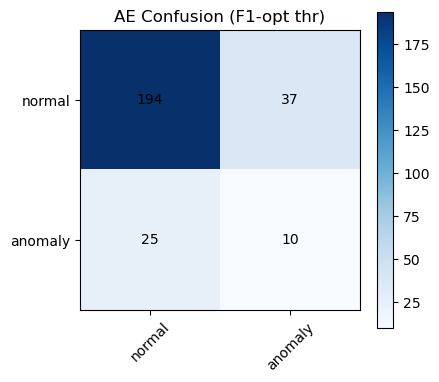

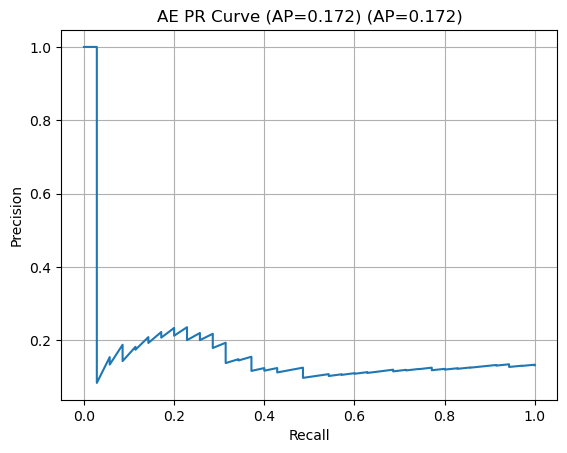

[AE] Wrote labeled scores -> /scratch/hdharmen/ASU/CSE 507/data/jsrt/autoencoder_img/ae_results/anomaly_scores_labeled.csv


In [18]:
# ===== Exercise 7: Evaluate AE anomaly scores (drop this right after your AE scoring CSV is written) =====
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, f1_score
import matplotlib.pyplot as plt

ae_scores_csv = AE_OUT / "anomaly_scores.csv"
assert ae_scores_csv.exists(), f"Missing: {ae_scores_csv}"

df = pd.read_csv(ae_scores_csv)   # columns: path,score,l1,1-ssim,is_anomaly
paths = [Path(p) for p in df["path"].tolist()]

# You already had these helpers earlier:
#  - discover_labels_from_paths(paths, task="ae")
#  - show_cm(...)
#  - plot_pr_curve(...)
y_true, map_ids = discover_labels_from_paths(paths, task="ae")
if y_true is None:
    print("[AE] No ground-truth labels found automatically. We'll treat this as unlabeled QC.")
else:
    s = df["score"].values.astype(float)  # higher = more anomalous
    auroc = roc_auc_score(y_true, s)
    ap = average_precision_score(y_true, s)
    print(f"[AE] AUROC={auroc:.3f} | AP={ap:.3f}  (1=best)")

    # --- Threshold by maximizing F1 on a tiny labeled subset (here: the whole set if labels exist) ---
    prec, rec, thr = precision_recall_curve(y_true, s)
    f1s = (2*prec*rec) / np.maximum(prec+rec, 1e-9)
    best_i = int(np.nanargmax(f1s))
    thr_star = thr[max(0, best_i-1)] if best_i < len(thr) else np.percentile(s, 95)
    print(f"[AE] F1-optimal threshold: {thr_star:.6f}  |  F1={f1s[best_i]:.3f}")
    y_pred = (s >= thr_star).astype(int)

    show_cm(y_true, y_pred, [map_ids[0], map_ids[1]], title="AE Confusion (F1-opt thr)")
    plot_pr_curve(y_true, s, title=f"AE PR Curve (AP={ap:.3f})")

    # Save a labeled CSV for records
    out_labeled = AE_OUT / "anomaly_scores_labeled.csv"
    df_lab = df.copy()
    df_lab["gt_anomaly"] = y_true
    df_lab["pred_anomaly"] = y_pred
    df_lab.to_csv(out_labeled, index=False)
    print(f"[AE] Wrote labeled scores -> {out_labeled}")


In [13]:
# ================================================================
# Exercise 8: Unsupervised Clustering (Directions01) with K-Means
# Dataset root: /scratch/hdharmen/ASU/CSE 507/data/jsrt/Directions01
# ================================================================

DIR_DATA = Path("/scratch/hdharmen/ASU/CSE 507/data/jsrt/Directions01")
DIR_OUT  = DIR_DATA / "cluster_results"
DIR_OUT.mkdir(parents=True, exist_ok=True)

# ---------- Dataset (optionally reads label from parent folder name) ----------
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

class DirectionsDataset(Dataset):
    def __init__(self, root, size=224, read_labels=True):
        self.paths = sorted([p for p in Path(root).rglob("*")
                             if p.suffix.lower() in {".png",".jpg",".jpeg",".bmp",".tif",".tiff"}])
        if len(self.paths) == 0:
            raise RuntimeError(f"No images under {root}")

        self.size = size
        self.read_labels = read_labels
        self.tf = transforms.Compose([
            transforms.Lambda(lambda im: im.convert("L")),
            transforms.Resize((size, size), interpolation=InterpolationMode.BILINEAR),
            transforms.Lambda(lambda im: Image.merge("RGB", (im,im,im))),
            transforms.ToTensor(),
            transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
        ])

    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        p = self.paths[i]
        x = self.tf(Image.open(p))
        if self.read_labels:
            y = p.parent.name  # folder name as label (optional, for eval only)
        else:
            y = None
        return x, str(p), y

ds_dir = DirectionsDataset(DIR_DATA, size=224, read_labels=True)
ld_dir = DataLoader(ds_dir, batch_size=64, shuffle=False, num_workers=workers(), pin_memory=True)

# ---------- Feature extractor (frozen) ----------
# Use ResNet18 -> global avgpool -> 512-d features
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet.fc = nn.Identity()
resnet.eval().to(DEVICE)
for p in resnet.parameters(): p.requires_grad = False

# ---------- Extract embeddings ----------
paths, labels_text, feats = [], [], []
with torch.no_grad():
    for xb, pths, labs in tqdm(ld_dir, desc="Embedding"):
        xb = xb.to(DEVICE, non_blocking=True)
        f = resnet(xb)                 # [B,512]
        feats.append(f.cpu().numpy())
        paths.extend(pths)
        labels_text.extend(labs)

X = np.concatenate(feats, axis=0)
print("Embeddings:", X.shape)

# Optional: standardize + PCA (helps KMeans)
scaler = StandardScaler()
Xn = scaler.fit_transform(X)
pca  = PCA(n_components=128, random_state=42)
Xp   = pca.fit_transform(Xn)
print("PCA:", Xp.shape, "Explained var (128 comps):", float(np.sum(pca.explained_variance_ratio_)))

# ---------- KMeans (k=5) ----------
K = 5
kmeans = KMeans(n_clusters=K, random_state=42, n_init="auto")
pred = kmeans.fit_predict(Xp)
centers = kmeans.cluster_centers_

# Silhouette (unsupervised quality metric; larger is better)
sil = silhouette_score(Xp, pred)
print(f"[Clustering] silhouette_score = {sil:.4f}")

# ---------- Save CSV ----------
with open(DIR_OUT/"clusters.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["path","cluster","label_optional"])
    for p, c, lab in zip(paths, pred, labels_text):
        writer.writerow([p, int(c), lab])

print(f"[Clustering] CSV saved to {DIR_OUT/'clusters.csv'}")

# ---------- Visualize a few per-cluster thumbnails ----------
thumbs_by_c = {c:[] for c in range(K)}
for p, c in zip(paths, pred):
    if len(thumbs_by_c[c]) >= 36:  # 36 per cluster grid
        continue
    img = Image.open(p).convert("L").resize((128,128), Image.BILINEAR)
    thumbs_by_c[c].append(np.array(img, dtype=np.uint8))

for c in range(K):
    save_grid(thumbs_by_c[c], DIR_OUT/f"cluster_{c:02d}.png", ncols=6)

print("Cluster grids saved under:", DIR_OUT)

# ---------- Optional: quick purity/accuracy if folder names are the true labels ----------
# (This does NOT affect training; it's only to report how well clusters align with known categories.)
try:
    from collections import Counter, defaultdict
    unique_labs = sorted(set(labels_text))
    if all(lab is not None for lab in labels_text) and len(unique_labs) <= 10:
        # Map each cluster to the majority label for a rough "purity"
        mapping = {}
        for c in range(K):
            labs_c = [lab for lab, cl in zip(labels_text, pred) if cl == c]
            if len(labs_c) == 0:
                mapping[c] = None
            else:
                mapping[c] = Counter(labs_c).most_common(1)[0][0]
        # compute purity
        correct = sum(1 for lab, cl in zip(labels_text, pred) if mapping[cl] == lab)
        purity = correct / len(labels_text)
        print(f"[Clustering] purity (cluster->majority-label) = {purity:.3f}")
        with open(DIR_OUT/"cluster_majority_map.json","w") as f:
            json.dump(mapping, f, indent=2)
        print("Majority map written:", DIR_OUT/"cluster_majority_map.json")
except Exception as e:
    print("Purity calc skipped:", e)


Embedding: 100%|██████████| 16/16 [00:10<00:00,  1.60it/s]


Embeddings: (993, 512)
PCA: (993, 128) Explained var (128 comps): 0.8978732824325562
[Clustering] silhouette_score = 0.0844
[Clustering] CSV saved to /scratch/hdharmen/ASU/CSE 507/data/jsrt/Directions01/cluster_results/clusters.csv
Cluster grids saved under: /scratch/hdharmen/ASU/CSE 507/data/jsrt/Directions01/cluster_results
[Clustering] purity (cluster->majority-label) = 0.755
Majority map written: /scratch/hdharmen/ASU/CSE 507/data/jsrt/Directions01/cluster_results/cluster_majority_map.json


In [15]:
# ===== Exercise 8: Build embeddings (Z) + cluster (pred_labels) for Directions01 =====
from pathlib import Path
import numpy as np, cv2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import torch

# ---- 1) Collect files deterministically
if 'dirs_paths' not in globals():
    DIRS_ROOT = Path("/scratch/hdharmen/ASU/CSE 507/data/jsrt/Directions01")
    IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}
    dirs_paths = sorted([p for p in DIRS_ROOT.rglob("*") if p.suffix.lower() in IMG_EXTS])
    print(f"[Clust] Found {len(dirs_paths)} images under {DIRS_ROOT}")

assert len(dirs_paths) > 0, "No images found for Directions01"

# ---- 2) Handcrafted, robust features (no internet / pretrained needed)
def img_to_features(path, size=256, canny1=50, canny2=150, nbins=8):
    """
    Returns a 1D feature vector capturing orientation, edges, symmetry and
    projection cues to separate up/down/left/right/flip.
    """
    im = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if im is None:
        raise RuntimeError(f"Failed to read image: {path}")
    im = cv2.resize(im, (size, size), interpolation=cv2.INTER_AREA)
    im_f = im.astype(np.float32) / 255.0

    # Sobel gradients & orientation histogram
    gx = cv2.Sobel(im_f, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(im_f, cv2.CV_32F, 0, 1, ksize=3)
    mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees=False)  # [0..2pi)
    # Weighted orientation histogram
    hist = np.zeros(nbins, dtype=np.float32)
    bin_edges = np.linspace(0.0, 2*np.pi, nbins+1, endpoint=True)
    inds = np.digitize(ang.ravel(), bin_edges) - 1
    inds = np.clip(inds, 0, nbins-1)
    for b in range(nbins):
        hist[b] = mag.ravel()[inds == b].sum()
    hist = hist / (hist.sum() + 1e-8)

    # Edge density (Canny)
    edges = cv2.Canny((im_f*255).astype(np.uint8), canny1, canny2)
    edge_density = edges.mean().astype(np.float32)

    # Horizontal/vertical projection profiles (normalized)
    row_proj = im_f.mean(axis=1)  # vertical energy distribution
    col_proj = im_f.mean(axis=0)  # horizontal energy distribution
    row_centroid = (row_proj * np.arange(size)).sum() / (row_proj.sum() + 1e-8) / size
    col_centroid = (col_proj * np.arange(size)).sum() / (col_proj.sum() + 1e-8) / size
    row_var = ((np.arange(size)/size - row_centroid)**2 * row_proj).sum() / (row_proj.sum() + 1e-8)
    col_var = ((np.arange(size)/size - col_centroid)**2 * col_proj).sum() / (col_proj.sum() + 1e-8)

    # Symmetry features (help detect flips)
    im_lr = np.fliplr(im_f)
    im_ud = np.flipud(im_f)
    # How different from its mirror?
    lr_diff = np.mean(np.abs(im_f - im_lr)).astype(np.float32)
    ud_diff = np.mean(np.abs(im_f - im_ud)).astype(np.float32)

    # Global stats
    mean = im_f.mean().astype(np.float32)
    std  = im_f.std().astype(np.float32)

    feat = np.concatenate([
        hist,                                  # nbins
        np.array([edge_density,                # 1
                  row_centroid, col_centroid,  # 2
                  row_var, col_var,            # 2
                  lr_diff, ud_diff,            # 2
                  mean, std], dtype=np.float32) # 2
    ], axis=0)
    return feat

# ---- 3) Extract features for all images (same order as dirs_paths)
X = np.stack([img_to_features(p) for p in dirs_paths], axis=0).astype(np.float32)
print(f"[Clust] Raw feature matrix: {X.shape}")  # (N, D)

# ---- 4) Normalize + reduce dimensionality
scaler = StandardScaler()
Xn = scaler.fit_transform(X)
pca = PCA(n_components=min(16, Xn.shape[1]), random_state=0)
Z = pca.fit_transform(Xn).astype(np.float32)     # embeddings the eval cell expects

print(f"[Clust] Embeddings Z: {Z.shape}")

# ---- 5) Cluster
n_clusters = 5  # up, down, left, right, flip
kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=0)
pred_labels = kmeans.fit_predict(Z).astype(int)

# Variables now exist for the eval block:
print(f"[Clust] pred_labels shape: {pred_labels.shape}, unique: {sorted(set(pred_labels))}")


[Clust] Found 993 images under /scratch/hdharmen/ASU/CSE 507/data/jsrt/Directions01
[Clust] Raw feature matrix: (993, 17)
[Clust] Embeddings Z: (993, 16)
[Clust] pred_labels shape: (993,), unique: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


[Clust] NMI=0.981 | ARI=0.989  (1=best)
[Clust] Purity=0.996  (1=best)
[Clust] Cluster->majority class mapping:
  cluster 0 -> down  (hits=246, size=247)
  cluster 1 -> right  (hits=246, size=247)
  cluster 2 -> left  (hits=246, size=247)
  cluster 3 -> up  (hits=246, size=247)
  cluster 4 -> cluster_results  (hits=5, size=5)


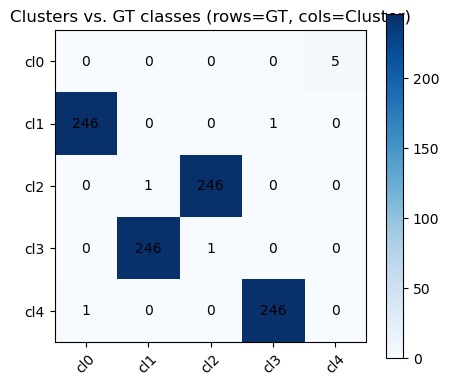

[Clust] Silhouette=0.411  (close to 1 is better separation)


In [16]:
# ===== Exercise 8: Evaluate clustering quality =====
from pathlib import Path
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

# You should already have something like:
#   DIRS_ROOT = Path("/scratch/hdharmen/ASU/CSE 507/data/jsrt/Directions01")
#   dirs_paths: list of image paths you clustered in exactly the same order as Z/pred_labels
#   Z: np.ndarray shape [N, D]  features used for clustering
#   pred_labels: np.ndarray shape [N] with cluster IDs (e.g., from KMeans)

# If you named them differently, adjust here:
assert 'pred_labels' in globals(), "Expected 'pred_labels' (cluster ids) in scope"
assert 'Z' in globals(), "Expected 'Z' (features) in scope"
assert 'dirs_paths' in globals(), "Expected 'dirs_paths' list aligned with Z/pred_labels"

y_true, name_to_id = discover_labels_from_paths(dirs_paths, task="dirs")
if y_true is None:
    print("[Clust] Could not infer labels from folder names. Skipping supervised metrics.")
else:
    # Canonical metrics that ignore label permutations
    nmi = normalized_mutual_info_score(y_true, pred_labels)
    ari = adjusted_rand_score(y_true, pred_labels)
    print(f"[Clust] NMI={nmi:.3f} | ARI={ari:.3f}  (1=best)")

    # Greedy best mapping cluster->class (for purity/confusion viz)
    clusters = sorted(set(pred_labels))
    classes  = sorted(set(y_true))
    C = len(clusters); K = len(classes)

    # build confusion between (cluster, class)
    conf = np.zeros((C, K), dtype=int)
    for c in clusters:
        idx = np.where(pred_labels == c)[0]
        cls, cnts = np.unique(y_true[idx], return_counts=True)
        for cl, ct in zip(cls, cnts):
            conf[c, cl] = ct

    # purity
    purity = conf.max(axis=1).sum() / conf.sum()
    print(f"[Clust] Purity={purity:.3f}  (1=best)")

    # Build a readable mapping
    id_to_class = {v:k for k,v in name_to_id.items()}
    class_names = [id_to_class[i] for i in range(K)]
    print("[Clust] Cluster->majority class mapping:")
    for c in clusters:
        maj_class = conf[c].argmax()
        print(f"  cluster {c} -> {id_to_class[maj_class]}  (hits={conf[c, maj_class]}, size={conf[c].sum()})")

    # Visual confusion heatmap with original class names
    show_cm(y_true, pred_labels, [f"cl{c}" for c in clusters], title="Clusters vs. GT classes (rows=GT, cols=Cluster)")

# Silhouette (optional; unsupervised, needs feature space)
try:
    sil = silhouette_score(Z, pred_labels, metric="euclidean")
    print(f"[Clust] Silhouette={sil:.3f}  (close to 1 is better separation)")
except Exception as e:
    print("[Clust] Silhouette not computed:", e)
